In [1]:
# jupyter nbconvert slides.ipynb --to slides --post serve

SyntaxError: invalid syntax (<ipython-input-1-3ea1bb47e443>, line 1)

# Jeryl Ong
## Capstone Project: My Grocery Finder (myGF)  
### An image classifier based on transfer learning and Convolutional Neural Networks

## Packages used
### Data Pre-Processing
1. pandas
2. cv2 (computer vision)
3. pickle
4. h5py

### Machine and Deep Learning
1. scikit-learn
2. keras
3. tensorflow

### Data Visualisation
1. matplotlib
2. seaborn

## Dataset
### Grozi dataset
Source: http://grozi.calit2.net/grozi.html  

Grozi is a database of grocery images from two main sources: 1) photographs and 2) the web. Our project is to utilise the photographs of 17 grocery items to predict their label. We may potentially integrate our classifier to predict grocery labels from images on the web.   

Here are the 17 grocery items and their labels:  

| Class | Grocery              |
|-------|----------------------|
| 0     | Wigglys gum          |
| 1     | Big red gum          |
| 2     | Hersheys Chocolate   |
| 3     | Twix                 |
| 4     | Snickers             |
| 5     | Tic Tac              |
| 6     | Dentyne ice          |

| Class | Grocery              |
|-------|----------------------|
| 7     | Starburst            |
| 8     | Rockstar             |
| 9     | Crunch               |
| 10    | Lays chips           |
| 11    | Milano biscuits      |
| 12    | Starbucks frappucino |
| 13    | Obertos beef jerky   |
| 14    | Honey nut cheerios   |
| 15    | Tostitos scoops      |
| 16    | Ruffles              |

## Workflow
### 1. Data Pre-Processing
### 2. Deep Learning:
    2.1 Transfer Learning
    2.2 Keras (tensorflow) Convolutional Neural Network
### 3. Results
### 4. Insights
### 5. Future Work


## 1. Data Pre-Processing

In [2]:
# Declaring img rows and cols (pixels)

img_rows= 128
img_cols= 128
num_channel= 3

# Get current directory

PATH = os.getcwd()
print(PATH)

C:\Users\Jeryl\Documents\Capstone\20180305 Capstone


## Image augmentation
Using the image generator from keras, to do random transformations to images. This effectively increases number of images per label to a level that is defined (in our case 1000 images).

In [ ]:
# Image augmentation
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

class_size=1000

# Specify source and destination paths for image generation
src_train_dir= os.path.join(PATH,'datasets', 'insitujpg')
dest_train_dir= os.path.join(PATH,'datasets', 'augment')

# Code to initialise ratio, then make images till images hit designated ratio (1000 image per class)

it = 0

In [9]:
# Use counts for individual values, generate enough images till it hits roughly 1000
for count in label_counts.values:
    #nb of generations per image for this class label in order to make it size ~= class_size
    ratio=math.floor(class_size/count)-1
    print(count,count*(ratio+1))
    dest_lab_dir=os.path.join(dest_train_dir,str(label_counts.index[it]))
    src_lab_dir=os.path.join(src_train_dir,str(label_counts.index[it]))
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
    for file in os.listdir(src_lab_dir):
        img=load_img(os.path.join(src_lab_dir,file))
        #img.save(os.path.join(dest_lab_dir,file))
        x=img_to_array(img) 
        x=x.reshape((1,) + x.shape)
        i=0
        for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_lab_dir, save_format='jpg'):
            i+=1
            if i > ratio:
                break 
    it=it+1
    
    

## Reading images into 128 by 128 matrix
Use cv2.imread to convert pixel values into 0 to 255, then divide by 255 to normalise the pixel values. Final image matrix: 128 by 128 pixel by 3 colour channels (RGB).

In [3]:
# Training dataset
# Read image using cv2, then append matrix to list

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
        
# Make matrix into numpy arrays, and normalise by dividing each pixel value by 255

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print (img_data.shape)        

Loaded the images of dataset-0

Loaded the images of dataset-1

Loaded the images of dataset-10

Loaded the images of dataset-11

Loaded the images of dataset-12

Loaded the images of dataset-13

Loaded the images of dataset-14

Loaded the images of dataset-15

Loaded the images of dataset-16

Loaded the images of dataset-2

Loaded the images of dataset-3

Loaded the images of dataset-4

Loaded the images of dataset-5

Loaded the images of dataset-6

Loaded the images of dataset-7

Loaded the images of dataset-8

Loaded the images of dataset-9



In [5]:
# Pickle to save arrays
pickle_out = open('X_conf','wb')
pickle.dump(img_data, pickle_out)
pickle_out.close()

del img_data


## 2. Deep Learning
### 2.1 Transfer Learning
https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/#0

In transfer learning, we will be making use of a pre trained convolutional neural network: mobilenet. We will retrain the model to make it classify our 17 grocery items.  

Retraining the model can be done using this few command line inputs:  
```
python -m scripts.retrain \
  --bottleneck_dir=tf_files/bottlenecks \
  --how_many_training_steps=1000 \
  --model_dir=tf_files/models/ \
  --summaries_dir=tf_files/training_summaries/"${ARCHITECTURE}" \
  --output_graph=tf_files/retrained_graph.pb \
  --output_labels=tf_files/retrained_labels.txt \
  --architecture="${ARCHITECTURE}" \
  --image_dir=tf_files/grocery photos
```

Here, we are designating the transfer learning script to retrain on architecture: mobilenet, and on our files: grocery photos. The model will be saved to the retrained_graph.pb and can be utilised in our python script for classification.

Next, we would define 3 functions to classify our image.   
- Function 1: load_graph, to load our rerained model  
- Function 2: read_tensor_from_image_file, to return the value of the class based on the model specified
- Function 3: load_labels, to load the class labels

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

import numpy as np
import tensorflow as tf


def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

In [ ]:
def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
    else:
        image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0)
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)

    return result

In [ ]:
def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

In [ ]:
# Load graph and labels
graph = load_graph('../tensorflow-for-poets-2/tf_files/retrained_graph.pb')
labels = load_labels('../tensorflow-for-poets-2/tf_files/retrained_labels.txt')

# Initialise parameters
input_height=128
input_width=128
input_mean=0
input_std=255

input_layer = "input"
output_layer = "final_result"

In [ ]:
# Simple for loop to iterate classifier over all images

y_pred = []
for dataset in data_dir_list:
    img_folder=os.path.join(image_location,dataset)
    img_dir = os.listdir(img_folder)
    for img in img_dir:
        file_name= os.path.join(image_location,dataset,img)
        t = read_tensor_from_image_file(
              file_name,
              input_height=input_height,
              input_width=input_width,
              input_mean=input_mean,
              input_std=input_std)

        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)

        

In [ ]:
with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: t
            })
            results = np.squeeze(results)

        top_k = results.argsort()[-5:][::-1]
        print('read image in folder: ', dataset, img)
        y_pred.append(labels[top_k[0]])

### 2.2 Building our own classifier using keras-tensorflow
By choosing to build our own classifier, we may enjoy benefits such as choosing the number of features to learn, optimiser to use for classification as well as the number of layers for learning.  

#### Defining the ConvNet model architecture

Model architecture = Convolution > relu > Convolution > relu > Max pool (with drop out) > Convolution > relu > convolution > relu > Max pool (drop out) > fully connected with activation > drop out > softmax activation.

Model is optimised using Adam (adaptive moment estimation):

- Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
- Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
- Adam is relatively easy to configure where the default configuration parameters do well on most problems.


In [6]:
# Defining the model
input_shape= (128,128,3)
num_classes = 17
model = Sequential()

model.add(Convolution2D(32, 3,border_mode='same',input_shape=input_shape, dim_ordering="tf"))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(64, 3,border_mode='same',input_shape=input_shape, dim_ordering="tf"))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

C:\ProgramData\Anaconda2\envs\py3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, data_format="channels_last", padding="same", input_shape=(128, 128,...)`
C:\ProgramData\Anaconda2\envs\py3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, data_format="channels_last", padding="same", input_shape=(128, 128,...)`


In [7]:
# Viewing model_configuration

model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
__________

True

####  Callbacks
The use of callbacks in keras allows you to monitor a metric and save the weights of model while training is in progress. Our metric of choice is validation loss. Whenever validation loss decreases, the weights of the particular model is saved

In [8]:
# Training with callbacks
from keras import callbacks

filename='model_train_new.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

# early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_log,checkpoint]

In [ ]:
# Training

num_epoch = 500
hist = model.fit(X_train, Y_train, batch_size=128,
                 epochs=num_epoch, 
                 validation_data=(X_test, Y_test),
                 callbacks=callbacks_list, verbose=2)

Train on 8243 samples, validate on 5010 samples
Epoch 1/500

Epoch 00001: val_loss improved from inf to 10.00096, saving model to Best-weights-my_model-001-1.9689-0.3564.hdf5
 - 55s - loss: 1.9689 - acc: 0.3564 - val_loss: 10.0010 - val_acc: 0.1405
Epoch 2/500

Epoch 00002: val_loss improved from 10.00096 to 9.19048, saving model to Best-weights-my_model-002-0.7649-0.7403.hdf5
 - 40s - loss: 0.7649 - acc: 0.7403 - val_loss: 9.1905 - val_acc: 0.1904
Epoch 3/500

Epoch 00003: val_loss did not improve
 - 39s - loss: 0.4673 - acc: 0.8418 - val_loss: 9.4057 - val_acc: 0.1739
Epoch 4/500

Epoch 00004: val_loss improved from 9.19048 to 9.07055, saving model to Best-weights-my_model-004-0.3579-0.8769.hdf5
 - 40s - loss: 0.3579 - acc: 0.8769 - val_loss: 9.0705 - val_acc: 0.2178
Epoch 5/500

Epoch 00005: val_loss improved from 9.07055 to 8.89021, saving model to Best-weights-my_model-005-0.2935-0.9009.hdf5
 - 39s - loss: 0.2935 - acc: 0.9009 - val_loss: 8.8902 - val_acc: 0.1711
Epoch 6/500

Epoc

#### Loss and accuracy visualisation

The loss and accuracy of our model is visualised using pyplot.

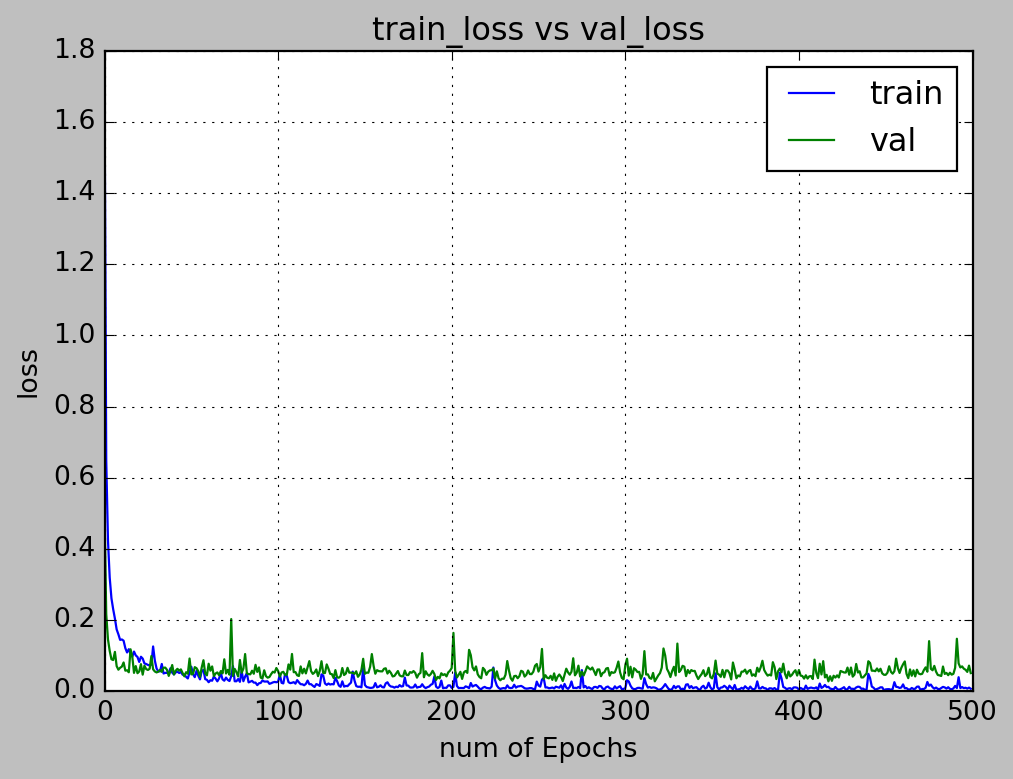

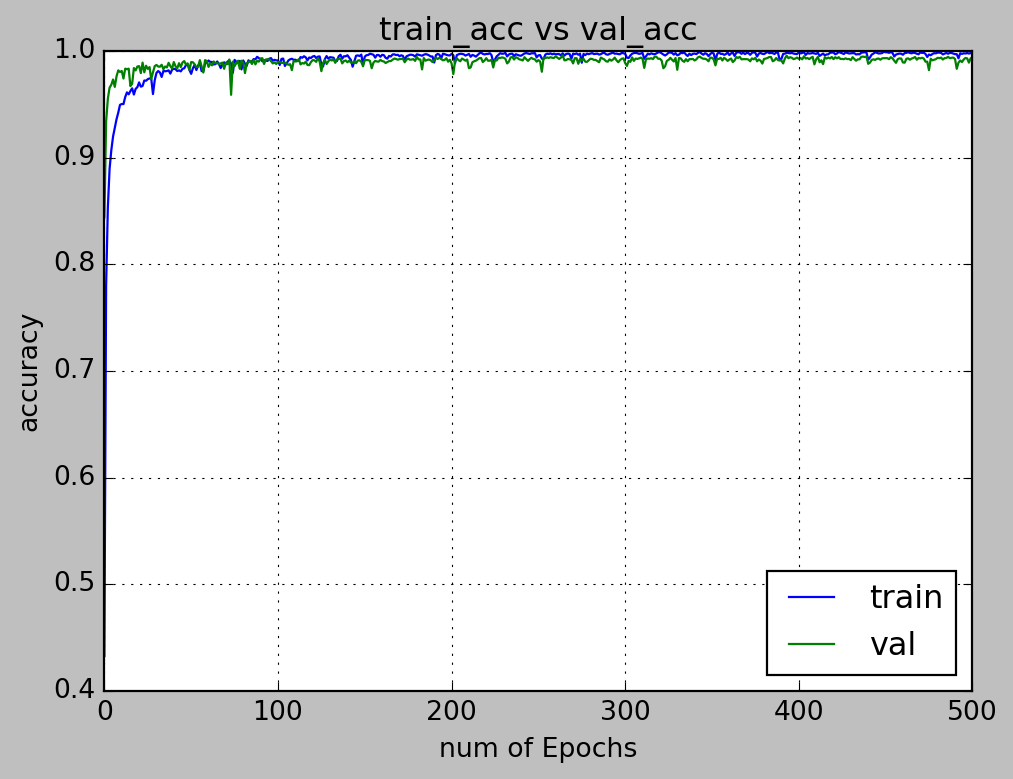

In [17]:
num_epoch = 500
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.savefig('dropall1.jpeg')

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.savefig('dropall2.jpeg')

![](./dropall_acc.jpeg)

![](./dropall_trainloss.jpeg)

### Results

Since the project is a classification of groceries, we can evaluate results based on confusion matrices. The confusion matrix essentially reports precision and recall.

Precision = tp÷(tp+fp)

The relation between true positives and the total number of true positives and false positives.

Recall = tp ÷ (tp+fn)

The relation between true positives to the total number of true positives and false negatives. 

![Wiki explaination](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

### Classification report and Confusion matrix
### Transfer learning

In [ ]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

  

In [65]:
  thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf_mat_tf.jpg')

In [66]:
# Compute confusion matrix

from sklearn.metrics import classification_report,confusion_matrix
import itertools

cnf_matrix = (confusion_matrix(y_true, y_pred))

np.set_printoptions(precision=2)

plt.figure()

Confusion matrix, without normalization
[[0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 3 0 0 2 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 1 2 0 2 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 1 2 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 2 1 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 4]]


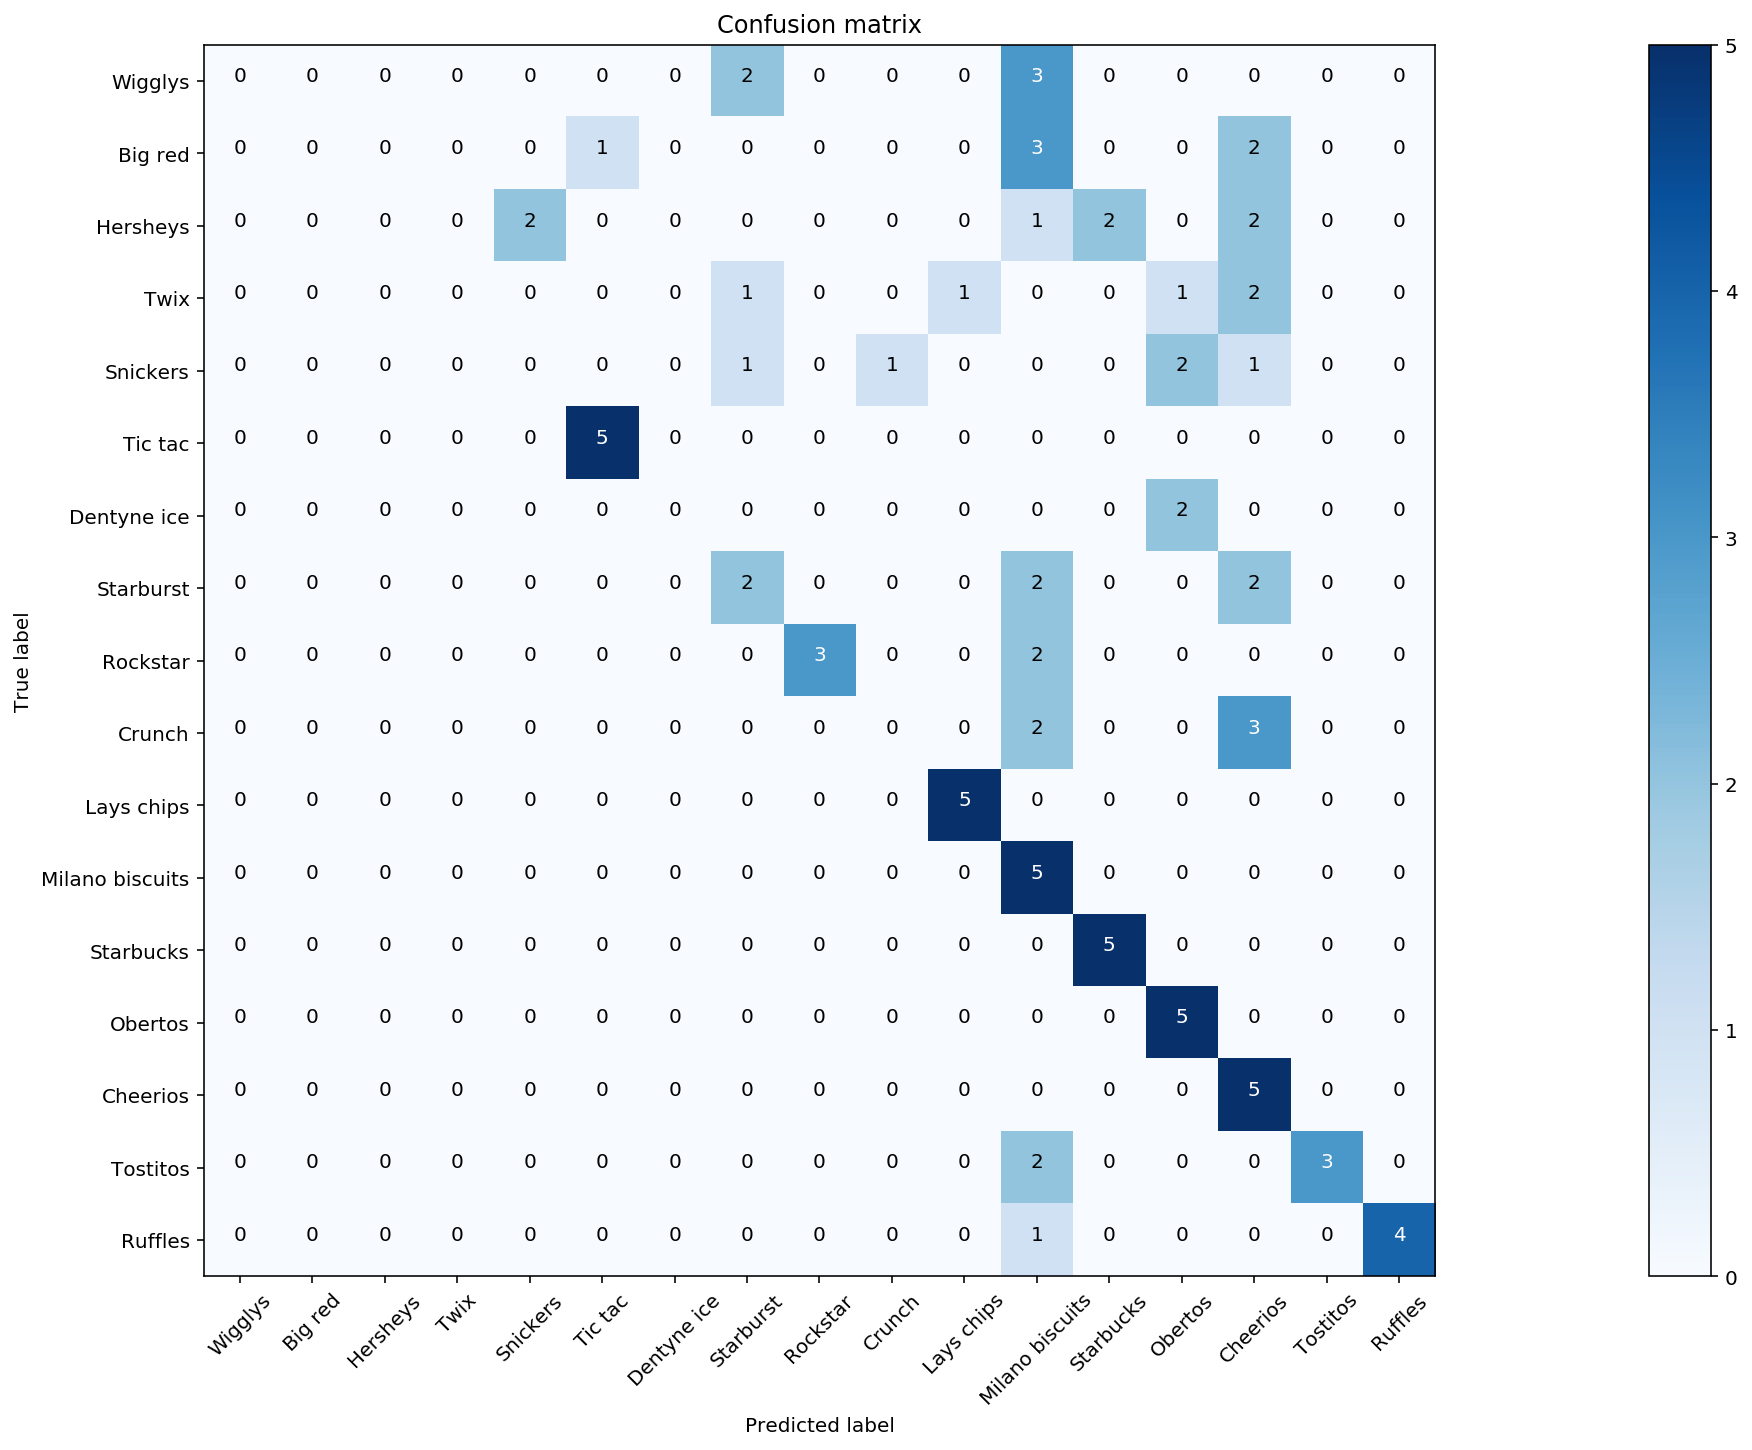

In [67]:
plt.figure(figsize=(30,10))


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
plt.figure()

![](./conf2.jpg)

In [68]:
print(classification_report(y_true, y_pred,target_names=target_names))

                 precision    recall  f1-score   support

        Wigglys       0.00      0.00      0.00         5
        Big red       0.00      0.00      0.00         6
       Hersheys       0.00      0.00      0.00         7
           Twix       0.00      0.00      0.00         5
       Snickers       0.00      0.00      0.00         5
        Tic tac       0.83      1.00      0.91         5
    Dentyne ice       0.00      0.00      0.00         2
      Starburst       0.33      0.33      0.33         6
       Rockstar       1.00      0.60      0.75         5
         Crunch       0.00      0.00      0.00         5
     Lays chips       0.83      1.00      0.91         5
Milano biscuits       0.24      1.00      0.38         5
      Starbucks       0.71      1.00      0.83         5
        Obertos       0.50      1.00      0.67         5
       Cheerios       0.29      1.00      0.45         5
       Tostitos       1.00      0.60      0.75         5
        Ruffles       1.00    

/home/Jeryl/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Keras - CNN

Confusion matrix, without normalization
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 2 0 3 3 2 0 3 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 1 0 3 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 2 0 0 0 0 0 6 0 0 0 0 0 0 5 0 0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 5]]


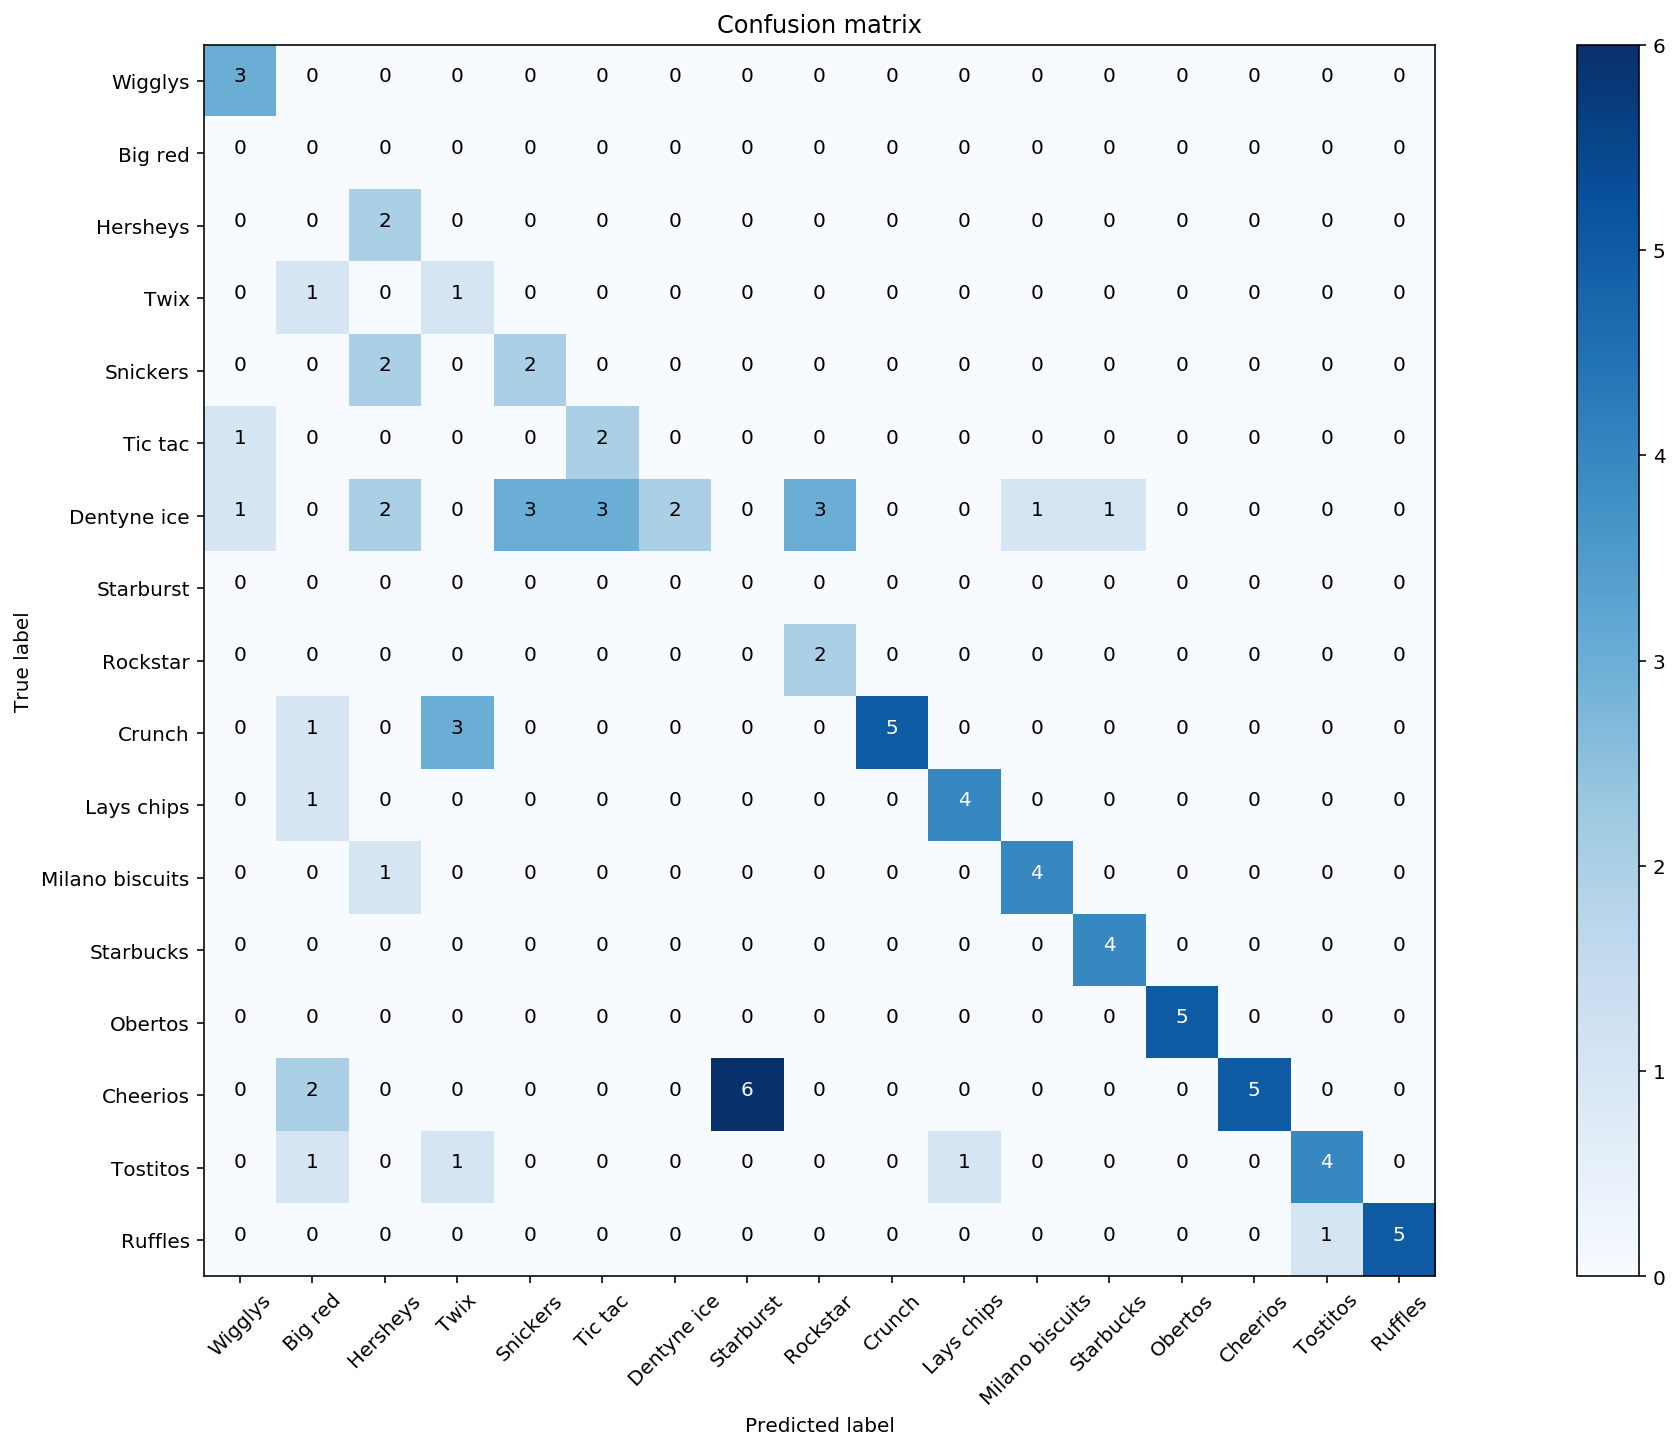

In [11]:
plt.figure(figsize=(20,10))
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
plt.figure()

# Plot normalized confusion matrix
# plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
#                      title='Normalized confusion matrix')
# plt.figure()
# plt.show()

![](./conf1.jpg)

In [8]:
print(classification_report(np.argmax(Y_pred,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(Y_pred,axis=1), y_pred))

                 precision    recall  f1-score   support

        Wigglys       0.60      1.00      0.75         3
        Big red       0.00      0.00      0.00         0
       Hersheys       0.29      1.00      0.44         2
           Twix       0.20      0.50      0.29         2
       Snickers       0.40      0.50      0.44         4
        Tic tac       0.40      0.67      0.50         3
    Dentyne ice       1.00      0.12      0.22        16
      Starburst       0.00      0.00      0.00         0
       Rockstar       0.40      1.00      0.57         2
         Crunch       1.00      0.56      0.71         9
     Lays chips       0.80      0.80      0.80         5
Milano biscuits       0.80      0.80      0.80         5
      Starbucks       0.80      1.00      0.89         4
        Obertos       1.00      1.00      1.00         5
       Cheerios       1.00      0.38      0.56        13
       Tostitos       0.80      0.57      0.67         7
        Ruffles       1.00    

/home/Jeryl/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Insights
1. Comparison between Transfer Learning and Keras  
    - Keras acheived an overall precision of 0.84 and recall of 0.58 as compared to the Transfer Learning model with an overall precision of 0.40 and recall of 0.49. 2 points can be discussed here. Point 1 being, as the support for grocery is low (about 5-6 images per grocery for classification), the recall will naturally be skewed greatly if 1 of 5 items is misclassified.    
    - To circumvent this, I suggest that we collect more data for the classification before proceeding to compute the confusion matrix and classification report.  
    - Also, for point 2, the transfer learning model only achieved ~ 0.4 precision and recall, which may be an indication that the model still has room for training. Since the number of iterations is only at 500, I suggest that we can retrain the model with more iterations (for example, 2000-5000 iterations). However, it must be performed with caution to prevent overfitting.  
    
2. Business use case
    Both the Transfer Learning model and Keras model have their pros and cons. Some of their advantages are as follows:  
    

2.1 ** Keras **
    - Full control of hyper-parameters
    - Full control of trainable features, depth and complexity of the model  

2.2 ** Transfer learning **
    - Easy to apply
    - Models from different domains may be applicable to business use cases from differing domains  
    
    From a business perspective, it is important to consider whether there is sufficient time to develop the model, or whether accuracy is preferred over speed and utility.
    
#### 3. ** Other models **
    Support Vector Machines, Fuzzy measures and Genetic Algorithms exist to classify images. But due to the time constraints of the capstone project, we are only able to explore deep learning, which is by far, out performing the other algorithms according to various research papers. It is still important to give the other models a try for a more in-depth comparison.